In [3]:
# In this notebook we implement a simple open cv blob detector
import cv2 as cv
import numpy as np

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from itertools import chain

cv.__version__

%load_ext autoreload
%autoreload 2

# Getting sample data

In [4]:
# Setting up capture
path = '/Users/gert-janboth/Documents/flyTracker/data/movies/short_test.mp4'
cap = cv.VideoCapture(path)

In [5]:
# some properties of video
length = cap.get(cv.CAP_PROP_FRAME_COUNT) # works only on mp4's
width  = cap.get(cv.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv.CAP_PROP_FRAME_HEIGHT)
fps    = cap.get(cv.CAP_PROP_FPS)

print(length, fps, width, height)

120.0 25.0 1280.0 1080.0


In [6]:
# Getting all frames into a numpy array for easy working
movie = []
for _ in np.arange(length):
    #frame_grayscale = cv.cvtColor(cap.read()[1], cv.COLOR_BGR2GRAY)
    movie.append(cap.read()[1])
movie = np.array(movie)    

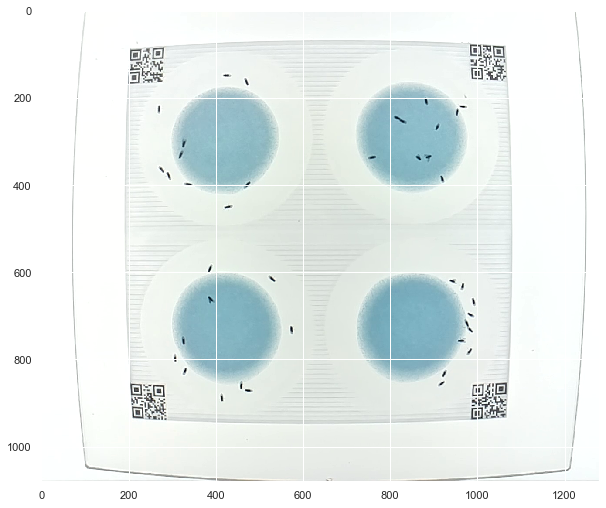

In [7]:
plt.figure(figsize=(10, 10))
frame = 99
plt.imshow(movie[frame])

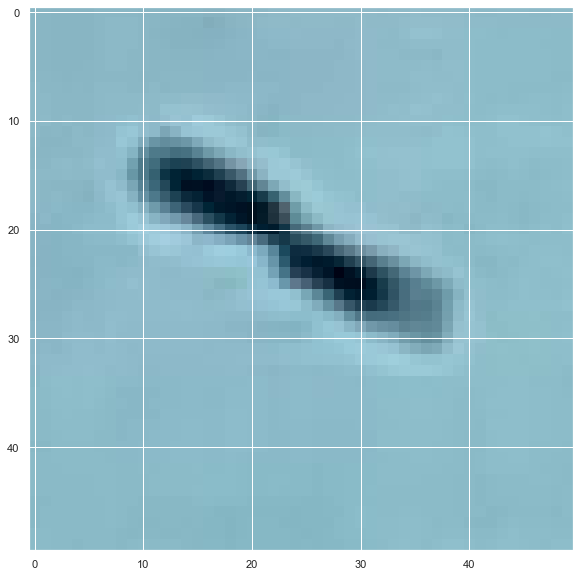

In [8]:
plt.figure(figsize=(10, 10))
frame = 99
plt.imshow(movie[frame, 230:280, 800:850])

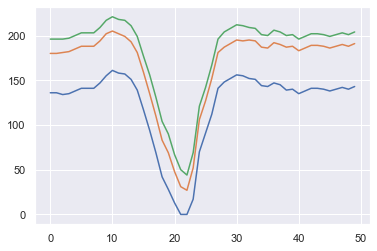

In [9]:
plt.plot(movie[frame, 250, 800:850])

# Preprocessing

In [10]:
from flytracker.preprocessing import OriginalPreprocessing

In [11]:
movie.shape[:3]

(120, 1080, 1280)

In [12]:
processed_movie = []
for idx in np.arange(movie.shape[0]):
    processed_frame = OriginalPreprocessing()(movie[idx])
    processed_movie.append(processed_frame)
processed_movie = np.array(processed_movie)

In [13]:
processed_movie.shape

(120, 1080, 1280)

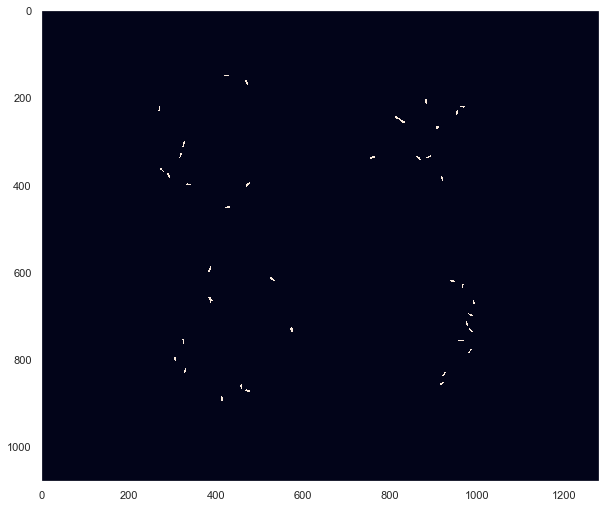

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(processed_movie[99])
plt.grid(False)

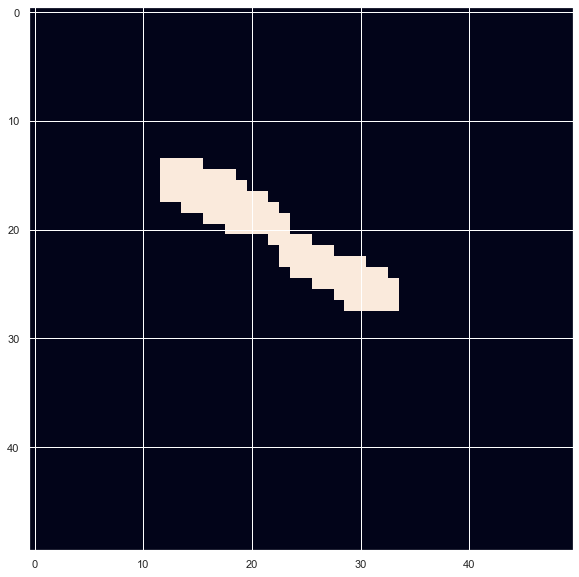

In [15]:
plt.figure(figsize=(10, 10))
frame = 99
plt.imshow(processed_movie[frame, 230:280, 800:850])

# Contour

In [14]:
frame = 99
processed_frame = processed_movie[frame, :, :]
raw_frame = movie[frame, :, :]

In [15]:
contours, hierarchy = cv.findContours(processed_frame, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [16]:
len(contours)

39

In [17]:
%%time

flies = []
for contour in contours:
    ellipse = cv.fitEllipse(contour)
    ellipse_flattened = list(chain(*(feature if isinstance(feature, tuple) else (feature,) for feature in ellipse))) # flattening data
    flies.append(ellipse_flattened)
#flies = np.array(flies)

CPU times: user 597 µs, sys: 370 µs, total: 967 µs
Wall time: 598 µs


In [18]:
len(flies)

39

In [19]:
np.array(flies).shape

(39, 5)

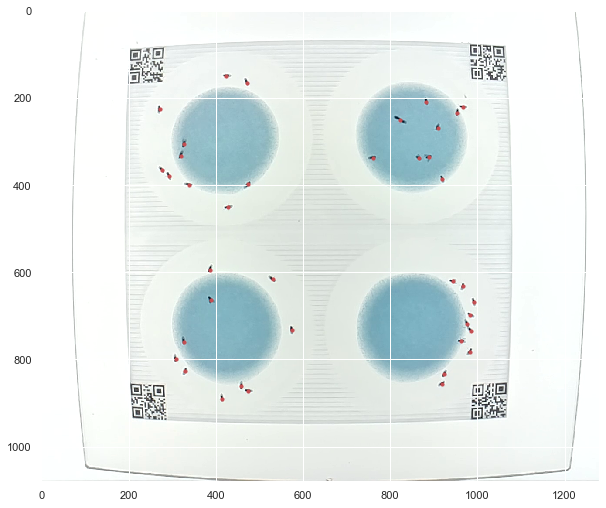

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(raw_frame)
plt.scatter(np.array(flies)[:, 0], np.array(flies)[:, 1], s=10, color='r')

Okay so there's an issue with two flies in the upper right. let's see if we can get some features and distinguish them:

In [21]:
arc_lengths = []
for contour in contours:
    arc_lengths.append(cv.arcLength(contour, closed=True))
arc_lengths = np.array(arc_lengths)

In [47]:
np.sum(processed_frame) / 40

18092.25

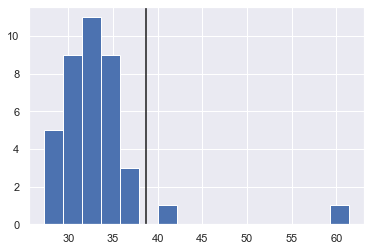

In [26]:
plt.hist(arc_lengths, bins='auto')
plt.axvline(np.mean(arc_lengths) + np.std(arc_lengths), color='k')
plt.show()

Clusters probably have a higher artc length, so the idea is to start with the biggest cluster, do watershed, update our estimate and make our way down until we have the right number of flies

In [27]:
max_arc_idx = np.argmax(arc_lengths)

In [28]:
max_arc_idx

32

In [29]:
bbox = cv.boundingRect(contours[max_arc_idx])

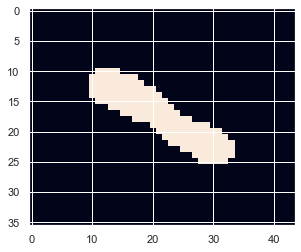

In [30]:
# Show where it goes wrong:
margin = 10
plt.imshow(processed_frame[bbox[1] - margin :bbox[1] + bbox[3] + margin, bbox[0] - margin :bbox[0] + bbox[2] + margin])

In [48]:
np.sum(processed_frame[bbox[1] - margin :bbox[1] + bbox[3] + margin, bbox[0] - margin :bbox[0] + bbox[2] + margin])

38505

In [31]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(processed_frame[bbox[1] - margin :bbox[1] + bbox[3] + margin, bbox[0] - margin :bbox[0] + bbox[2] + margin],cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=2)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform, 0.7*dist_transform.max(), 255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers[markers>1] = 2

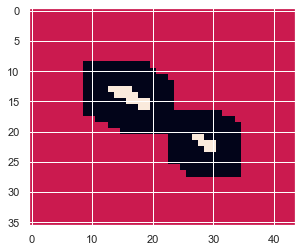

In [32]:
plt.imshow(markers)

In [33]:
markers = cv.watershed(raw_frame[bbox[1] - margin :bbox[1] + bbox[3] + margin, bbox[0] - margin :bbox[0] + bbox[2] + margin],markers)
markers[markers <= 0] = 1
markers -= 1

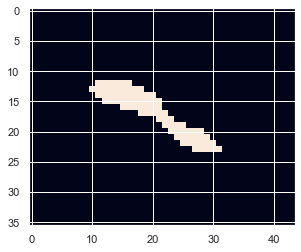

In [34]:
plt.imshow(markers)

In [195]:
np.unique(markers)

array([0, 1], dtype=int32)

In [196]:
np.unique(markers, return_counts=True)

(array([0, 1], dtype=int32), array([1504,   56]))

In [197]:
np.unique(markers)

array([0, 1], dtype=int32)

In [198]:
local_contours = cv.findContours(markers.astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]

In [199]:
len(local_contours)

2

In [200]:
# deleting the old marker
contours.pop(max_arc_idx)
flies.pop(max_arc_idx)

[857.677001953125,
 324.55938720703125,
 8.76762580871582,
 24.73883819580078,
 130.17791748046875]

In [201]:
len(flies)

38

In [202]:
# Adding new contours and ellipses
contours.extend(local_contours)
for contour in local_contours:
    ellipse = cv.fitEllipse(contour.astype(np.float32))
    ellipse_flattened = list(chain(*(feature if isinstance(feature, tuple) else (feature,) for feature in ellipse))) # flattening data
    ellipse_flattened[0] += bbox[0] - margin
    ellipse_flattened[1] += bbox[1] - margin
    flies.append(ellipse_flattened)

In [203]:
len(contours)

40

In [204]:
len(flies)

40

In [205]:
len(flies)

40

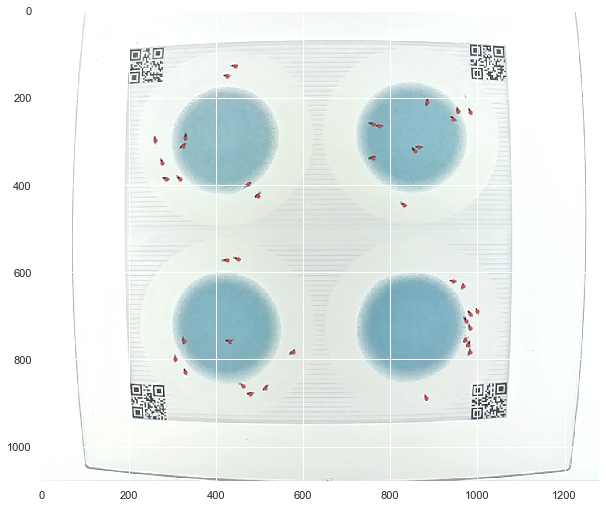

In [152]:
plt.figure(figsize=(10, 10))
plt.imshow(movie[frame, :, :])
plt.scatter(np.array(flies)[:, 0], np.array(flies)[:, 1], s=10, color='r')

# Redoing in nice function

In [218]:
frame = 99
processed_frame = processed_movie[frame, :, :]
raw_frame = movie[frame, :, :]

In [219]:
%%time
# settings and empty data
margin = 10
n_flies = 40
flies = []
arc_lengths = []

# fitting ellipses to contours
contours = cv.findContours(processed_frame, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
for contour in contours:
    ellipse = cv.fitEllipse(contour)
    arc_lengths.append(cv.arcLength(contour, closed=True))
    ellipse_flattened = list(chain(*(feature if isinstance(feature, tuple) else (feature,) for feature in ellipse))) # flattening data
    flies.append(ellipse_flattened)

CPU times: user 2.35 ms, sys: 2.03 ms, total: 4.38 ms
Wall time: 2.28 ms


In [220]:
def watershed(processed_frame, raw_frame, bbox):
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(processed_frame[bbox[1] - margin :bbox[1] + bbox[3] + margin, bbox[0] - margin :bbox[0] + bbox[2] + margin],cv.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers[markers>1] = 2
    
    markers = cv.watershed(raw_frame[bbox[1] - margin :bbox[1] + bbox[3] + margin, bbox[0] - margin :bbox[0] + bbox[2] + margin],markers)
    markers[markers <= 0] = 1
    markers -= 1
    
    return markers

In [221]:
%%time 
if len(flies) != n_flies:
    # Finding bbox of maximum arc length
    max_arc_idx = np.argmax(arc_lengths)
    bbox = cv.boundingRect(contours[max_arc_idx])
    
    # Doing watershed to separate
    markers = watershed(processed_frame, raw_frame, bbox)
    
    # Updating contours
    local_contours = cv.findContours(markers.astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
    
    # deleting the old marker
    contours.pop(max_arc_idx)
    flies.pop(max_arc_idx)
    # Adding new contours and ellipses
    contours.extend(local_contours)
    for contour in local_contours:
        ellipse = cv.fitEllipse(contour.astype(np.float32))
        ellipse_flattened = list(chain(*(feature if isinstance(feature, tuple) else (feature,) for feature in ellipse))) # flattening data
        ellipse_flattened[0] += bbox[0] - margin
        ellipse_flattened[1] += bbox[1] - margin
        flies.append(ellipse_flattened)

CPU times: user 1.13 ms, sys: 1.03 ms, total: 2.16 ms
Wall time: 1.26 ms


In [223]:
len(flies)

39

# Frame with 38 flies:

In [211]:
from flytracker.localizing import OriginalLocalising

In [212]:
localizer = OriginalLocalising()

# SKlearn

In [118]:
image = processed_movie[frame, 230:280, 800:850]

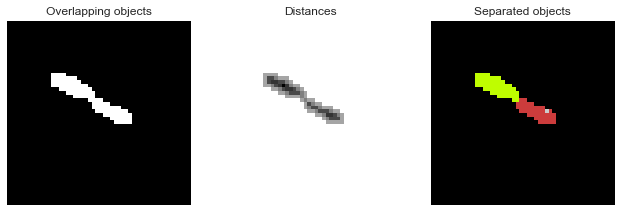

In [123]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, 2, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()


In [121]:
np.unique(labels)

array([ 0, 17, 25, 26], dtype=int32)

Felzenszwalb number of segments: 7
SLIC number of segments: 3
Quickshift number of segments: 5


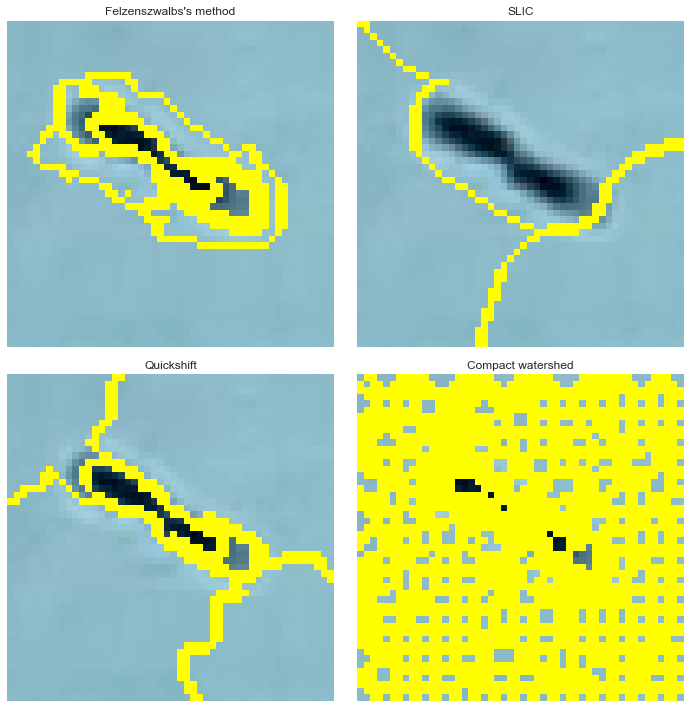

In [86]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = img_as_float(movie[frame, 230:280, 800:850])

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=30)
segments_slic = slic(img, n_segments=3, compactness=5, sigma=5)
segments_quick = quickshift(img, kernel_size=3, max_dist=10, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [91]:
from skimage.filters import threshold_multiotsu
image = movie[frame, 230:280, 800:850]

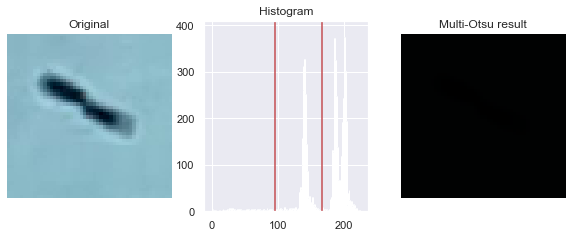

In [92]:
# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='Accent')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

In [94]:
from skimage import data, img_as_float
from skimage.segmentation import chan_vese

In [97]:
image.shape

(50, 50, 3)

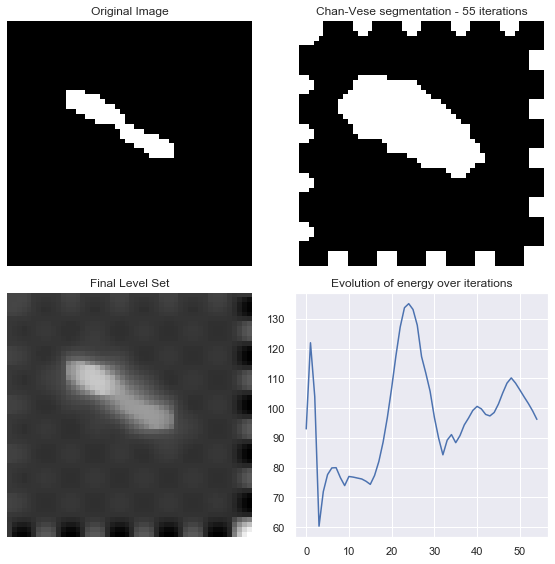

In [102]:
# Feel free to play around with the parameters to see how they impact the result
image = img_as_float(processed_movie[frame, 230:280, 800:850])
cv = chan_vese(image, mu=0.5, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

In [16]:
%%time
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure
from skimage.color import rgb2gray

c = []
for frame in np.arange(100):
    # Construct some test data
    r = processed_movie[frame, :, :]

    # Find contours at a constant value of 0.8
    contours = measure.find_contours(r, 0.1)
    c.append(len(contours))

CPU times: user 990 ms, sys: 69.3 ms, total: 1.06 s
Wall time: 1.06 s


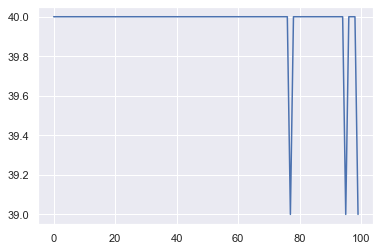

In [17]:
plt.plot(c)

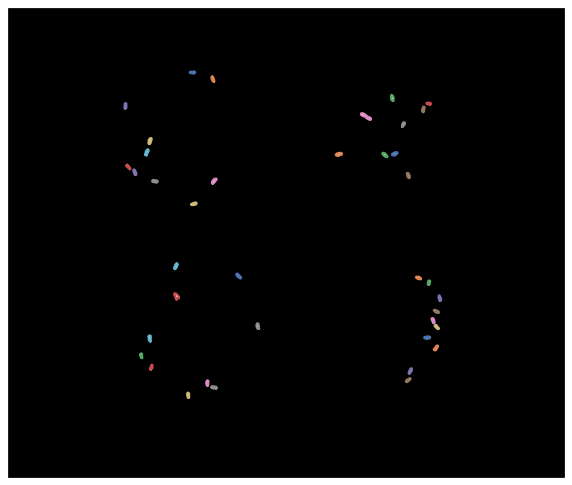

In [18]:
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(r, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()